In [4]:
import sys
sys.path.append('..')

In [5]:
from pcd_dataset import PointCloudDataset
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

import shapely
from shapely import Polygon
from simplification.cutil import simplify_coords_vw

from detect_ceiling import detect_ceiling_peaks, extract_ceiling_levels, refine_all_ceiling_levels
from sklearn.model_selection import ParameterGrid
from get_dimentions import *
from get_boundary import *
from detect_floor import *
from detect_walls import *
from finetune import *
from merge_walls import *

import warnings
warnings.filterwarnings('ignore')

In [6]:
FILE = "../data/alex5.ply"

In [7]:
s_val = PointCloudDataset(FILE, 0.02)

In [152]:
# s_val.visualize_pcd("raw")

In [8]:
s_val.clean_pcd(method='radius', nb=20, r=0.05)

In [9]:
# s_val.visualize_pcd("cleaned")

In [10]:
# sem_seg.ransac_segmentor.visualize_segments()

In [11]:
points = np.array(s_val.cleaned_pcd.points)

### CEILING

In [12]:
def detect_ceiling_correct(points, 
                          top_percentile=95,  # Look at top 5% of heights
                          thickness=0.10):
    """
    Detect ceiling by looking at HIGHEST points, not most dense cluster
    """
    
    z_coords = points[:, 2]
    
    print(f"\n{'='*70}")
    print(f"CEILING DETECTION (HEIGHT-BASED)")
    print(f"{'='*70}")
    print(f"Z range: [{z_coords.min():.3f}m, {z_coords.max():.3f}m]")
    
    # Step 1: Get top percentile
    z_threshold = np.percentile(z_coords, top_percentile)
    
    print(f"\nTop {100-top_percentile}% height threshold: {z_threshold:.3f}m")
    
    # Step 2: Extract top points
    top_mask = z_coords >= z_threshold
    top_points = points[top_mask]
    
    print(f"Points above threshold: {len(top_points):,}")
    
    if len(top_points) < 100:
        print(f"❌ Too few top points!")
        return np.array([], dtype=int)
    
    # Step 3: Find densest cluster in top points using histogram
    top_z = top_points[:, 2]
    hist, bin_edges = np.histogram(top_z, bins=50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Find peak in top region
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(hist, prominence=len(top_points) * 0.05)
    
    if len(peaks) == 0:
        # No clear peak, use highest point
        ceiling_height = top_z.max()
        print(f"No clear peak, using max height: {ceiling_height:.3f}m")
    else:
        # Get HIGHEST peak (ceiling is at top!)
        peak_heights = bin_centers[peaks]
        ceiling_height = peak_heights.max()
        print(f"Found {len(peaks)} peaks in top region")
        print(f"Highest peak at: {ceiling_height:.3f}m")
    
    # Step 4: Extract ceiling points (within thickness)
    ceiling_mask = np.abs(z_coords - ceiling_height) <= thickness
    ceiling_indices = np.where(ceiling_mask)[0]
    
    print(f"\nCeiling height: {ceiling_height:.3f}m")
    print(f"Ceiling points: {len(ceiling_indices):,} ({100*len(ceiling_indices)/len(points):.1f}%)")
    
    return ceiling_indices
    

In [13]:
ceiling_indices = detect_ceiling_correct(points)


CEILING DETECTION (HEIGHT-BASED)
Z range: [-1.839m, 1.249m]

Top 5% height threshold: 1.066m
Points above threshold: 12,305
Found 1 peaks in top region
Highest peak at: 1.126m

Ceiling height: 1.126m
Ceiling points: 14,865 (6.0%)


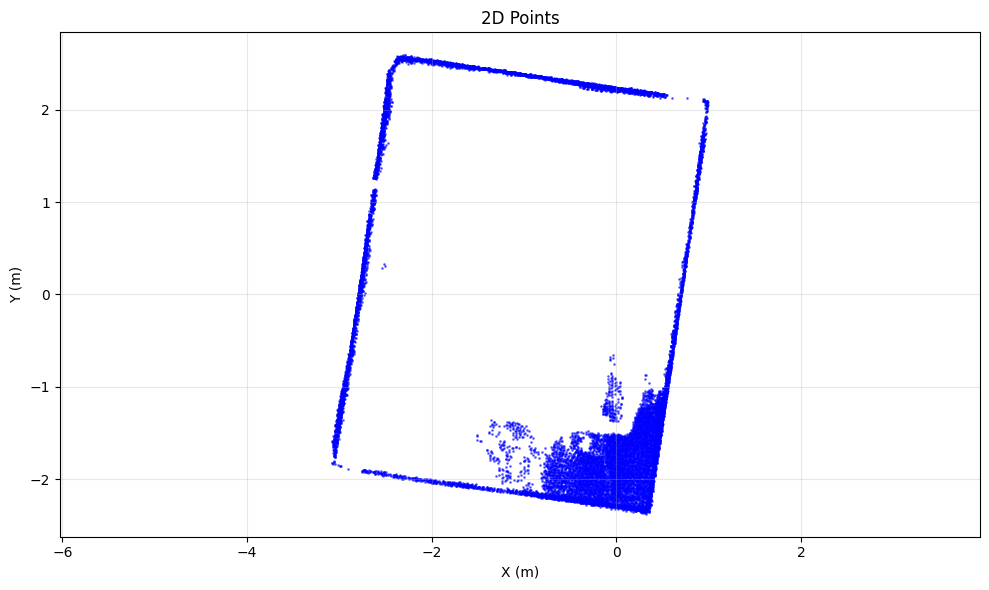

In [14]:
ceiling_points_2d = points[ceiling_indices, :2]
visualize_2d_points(ceiling_points_2d, downsample=1)

### WALL

In [16]:
segmentation = segment_floor_ceiling_walls(
    points,
    ceiling_indices=ceiling_indices,
    floor_method='histogram_ransac',
    bottom_slice_height=0.50,
    floor_ransac_threshold=0.02
)


  Running RANSAC on bottom slice only...
    ✓ Plane is horizontal
    RANSAC inliers in slice: 28,596
    Expanded to all points (±0.1m): 36,869
    Additional floor points found: 8,273

Room height:    2.879m (floor: -1.762m, ceiling: 1.117m)


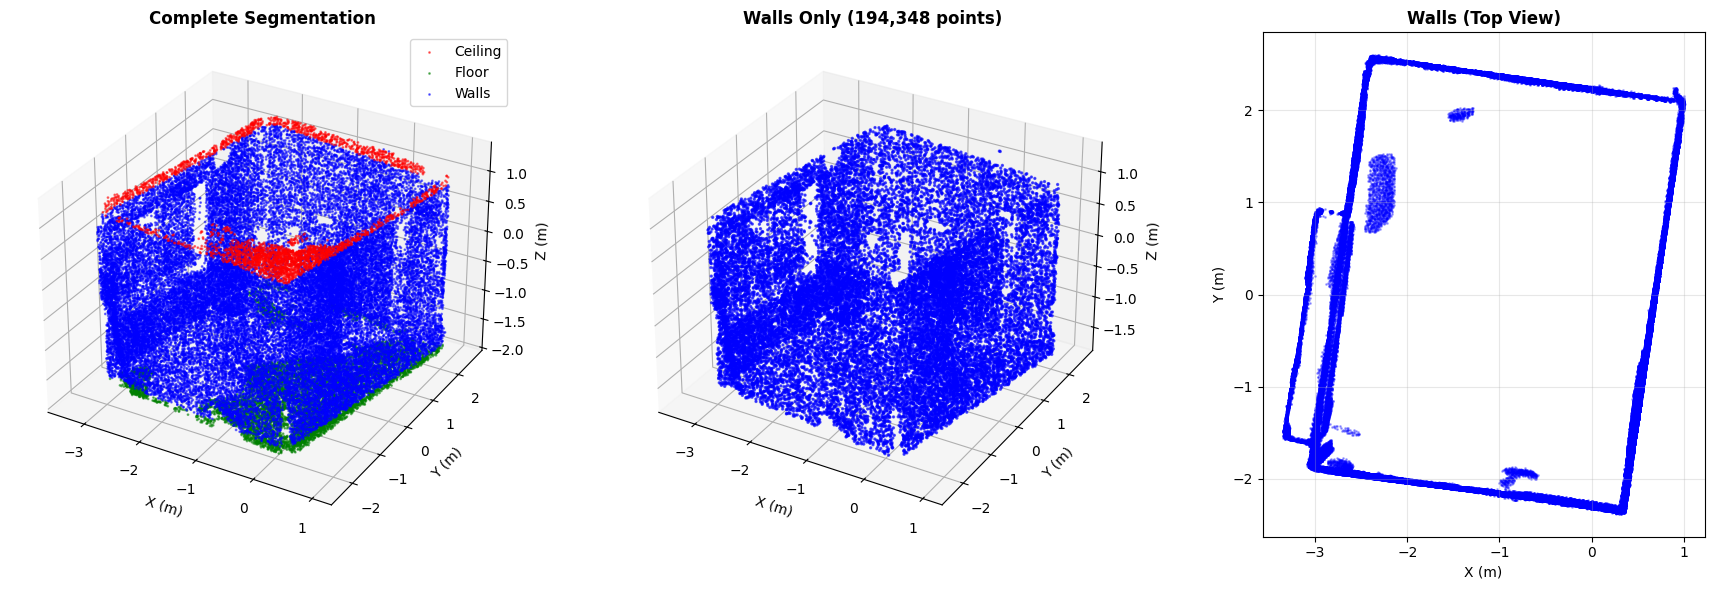

In [17]:
visualize_segmentation(points, segmentation, subsample=50000)

In [18]:
floor_height, ceiling_height = segmentation["floor_height"], segmentation["ceiling_height"]

In [21]:
wall_result = extract_walls_complete_pipeline(
    points,
    floor_height=floor_height,
    ceiling_height=ceiling_height,
    floor_margin=0.10,        # 10cm margin
    ceiling_margin=0.25,      # 10cm margin
    normal_radius=0.10,       # 10cm for normal estimation
    max_nn=30,
    vertical_threshold=0.15   # |normal_z| < 0.15 = vertical
)

  Excluded: 62,302 points (25.3%)


In [22]:
vertical_points = wall_result["wall_points"]
vertical_normals = wall_result["wall_normals"]

In [24]:
# visualize_wall_points_3d(vertical_points, vertical_normals)

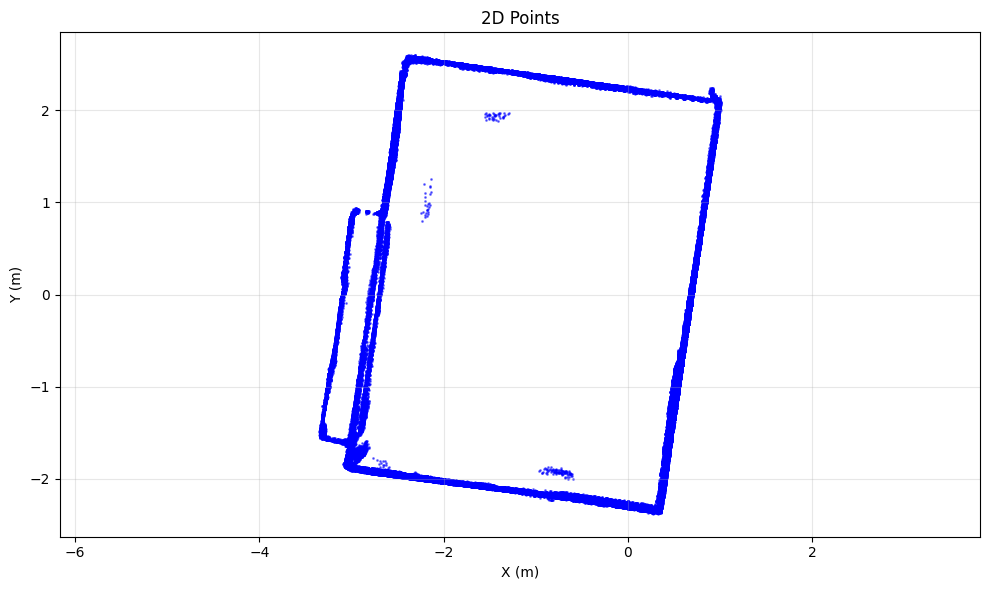

In [23]:
wall_points_2d = vertical_points[: , :2]
visualize_2d_points(wall_points_2d)

In [24]:
walls = detect_walls_ransac_clustering(
    vertical_points,
    floor_height=floor_height,
    ceiling_height=ceiling_height,
    distance_threshold=0.02,      # 3cm RANSAC
    cluster_eps=0.12,             # 12cm clustering
    min_cluster_points=50,       # At least 100 points
    min_wall_height=1.8,          # At least 1.8m tall
    min_wall_length=0.10,         # At least 80cm long
    max_wall_thickness=0.25,      # Max 25cm thick
    min_height_ratio=0.60,        # Must span 60% of room height
    max_iterations=30
)

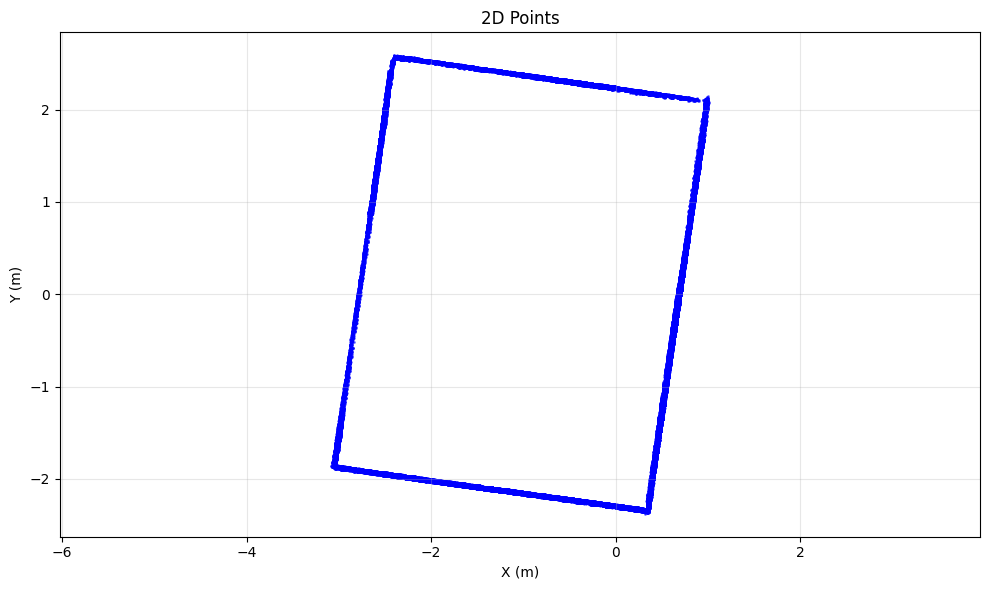

In [25]:
wall_points = get_room_wall_points(walls)
wall_points_2d = project_points_to_2d(wall_points)
visualize_2d_points(wall_points_2d)

In [26]:
visualize_each_wall_independetly_3d(walls=walls)

In [27]:
pairs = find_parallel_wall_pairs(walls)

In [29]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.vstack([wall["points"] for wall in walls]))
room_center = pcd.compute_mean_and_covariance()[0]

### Approach 1

In [30]:
merged_walls, removed_indices = select_inner_walls(walls, pairs, room_center)


Walls: 4 → 4


In [31]:
print(f"\nRemoved walls (outer layers): {removed_indices}")
print(f"Kept walls (inner layers): {[i for i in range(len(walls)) if i not in removed_indices]}")


Removed walls (outer layers): set()
Kept walls (inner layers): [0, 1, 2, 3]


In [32]:
visualize_each_wall_independetly_3d(walls=merged_walls)

In [33]:
[wall["thickness"] for wall in merged_walls]

[np.float64(0.045923868241825705),
 np.float64(0.05911487136562121),
 np.float64(0.0512409929973332),
 np.float64(0.05740937304572524)]

In [34]:
refined_walls = []

for i, wall in enumerate(merged_walls):
    print(f"\n{'#'*70}")
    print(f"WALL {i+1} / {len(merged_walls)}")
    print(f"{'#'*70}")
    
    wall_points = wall['points']
    plane_normal = wall['normal']
    plane_point = wall_points.mean(axis=0)
    
    # Extract thin inner boundary in cm
    inner_points, stats = extract_inner_boundary_only(
        wall_points=wall_points,
        plane_normal=plane_normal,
        plane_point=plane_point,
        room_center=room_center,
        boundary_thickness=0.02
    )
    
    refined_walls.append({
        'points': inner_points,
        'normal': plane_normal,
        'statistics': stats
    })
    
    print(f"\nWall {i+1} summary:")
    print(f"  Original thickness: {stats['thickness']*100:.1f}cm")
    print(f"  Extracted layer: {stats['boundary_thickness']*100:.1f}cm")
    print(f"  Points: {len(wall_points):,} → {len(inner_points):,}")
    print(f"  Reduction: {(1 - stats['filter_ratio'])*100:.1f}%")


######################################################################
WALL 1 / 4
######################################################################

EXTRACTING INNER BOUNDARY (THIN LAYER)
Input points: 35,976
Boundary thickness: 2.0cm
  Normal flipped: False
  Wall thickness: 4.8cm
  Distance range: [-2.6cm, 2.3cm]
  Innermost surface at: 2.3cm from fitted plane
  Keep points in range: [0.3cm, 2.3cm]
  Points kept: 15,815 (44.0%)

RESULT: 35,976 → 15,815 points
Reduction: 56.0%


Wall 1 summary:
  Original thickness: 4.8cm
  Extracted layer: 2.0cm
  Points: 35,976 → 15,815
  Reduction: 56.0%

######################################################################
WALL 2 / 4
######################################################################

EXTRACTING INNER BOUNDARY (THIN LAYER)
Input points: 36,841
Boundary thickness: 2.0cm
  Normal flipped: True
  Wall thickness: 4.6cm
  Distance range: [-2.1cm, 2.5cm]
  Innermost surface at: 2.5cm from fitted plane
  Keep points in range: [

In [35]:
visualize_each_wall_independetly_3d(walls=refined_walls)

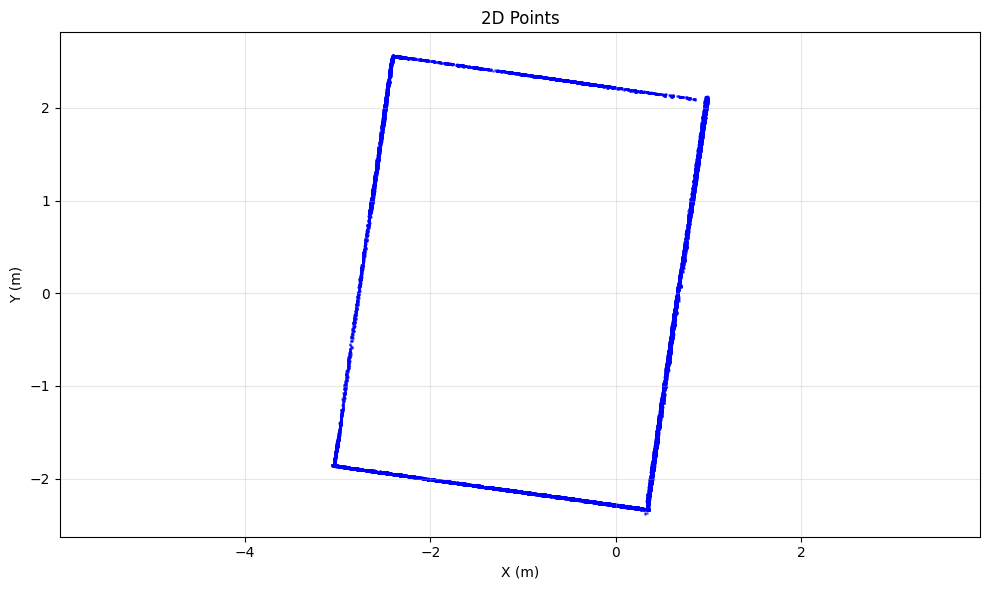

In [36]:
visualize_2d_points(np.vstack([wall["points"] for wall in refined_walls])[:, : 2])

#### CALCULATE DIMENSIONS

In [37]:
a, b, c, d = (900 + 2410 + 110) / 1000, 4485 / 1000, 3420 / 1000, 4485 / 1000
p = a + b + c + d 
S = 15.34

In [38]:
median_thickness = 0.00

In [39]:
all_wall_points = get_room_wall_points(refined_walls)
wall_points_2d = all_wall_points[:, :2]

### workflow

In [40]:
boundary_polygon = extract_room_boundary_from_walls(
    wall_points_2d,
    method='concave_hull',
    concave_ratio=0.6912824878709039
)

In [41]:
offset_implicit = offset_boundary_inward(
    boundary_polygon,
    offset_distance=median_thickness
) 

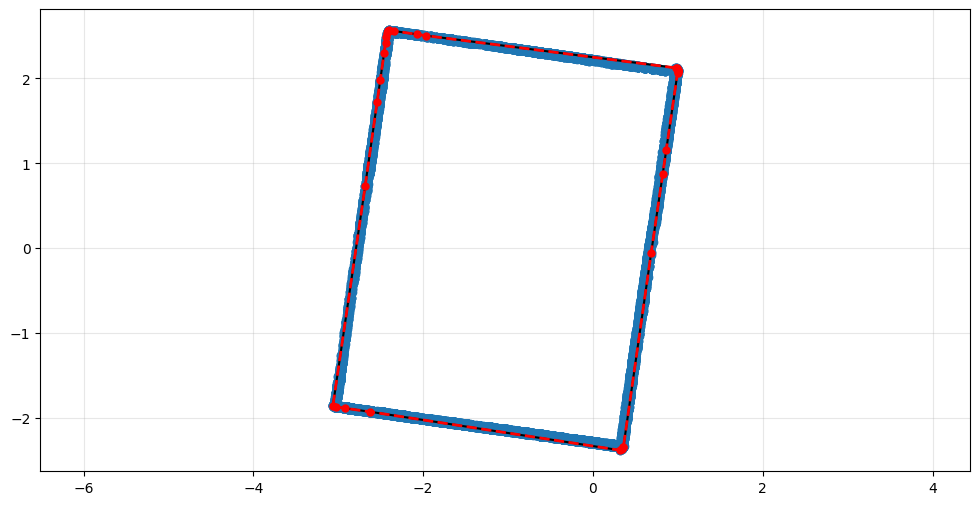

In [42]:

plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

if offset_implicit.geom_type == 'Polygon':
    # get boundary coordinates
    x, y = offset_implicit.exterior.xy
    coords = np.array(list(zip(x, y)))
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()


POLYGON DIMENSIONS
Number of corners: 6
Wall  1: Corner 1 → Corner 2, Length:  3.423m, Angle:  352.7°
Wall  2: Corner 2 → Corner 3, Length:  0.059m, Angle:  284.4°
Wall  3: Corner 3 → Corner 4, Length:  4.449m, Angle:  261.8°
Wall  4: Corner 4 → Corner 5, Length:  0.057m, Angle:  228.9°
Wall  5: Corner 5 → Corner 6, Length:  3.425m, Angle:  171.3°
Wall  6: Corner 6 → Corner 1, Length:  4.471m, Angle:   81.6°

──────────────────────────────────────────────────────────────────────
Total perimeter: 15.884m
Total area:      15.565m²


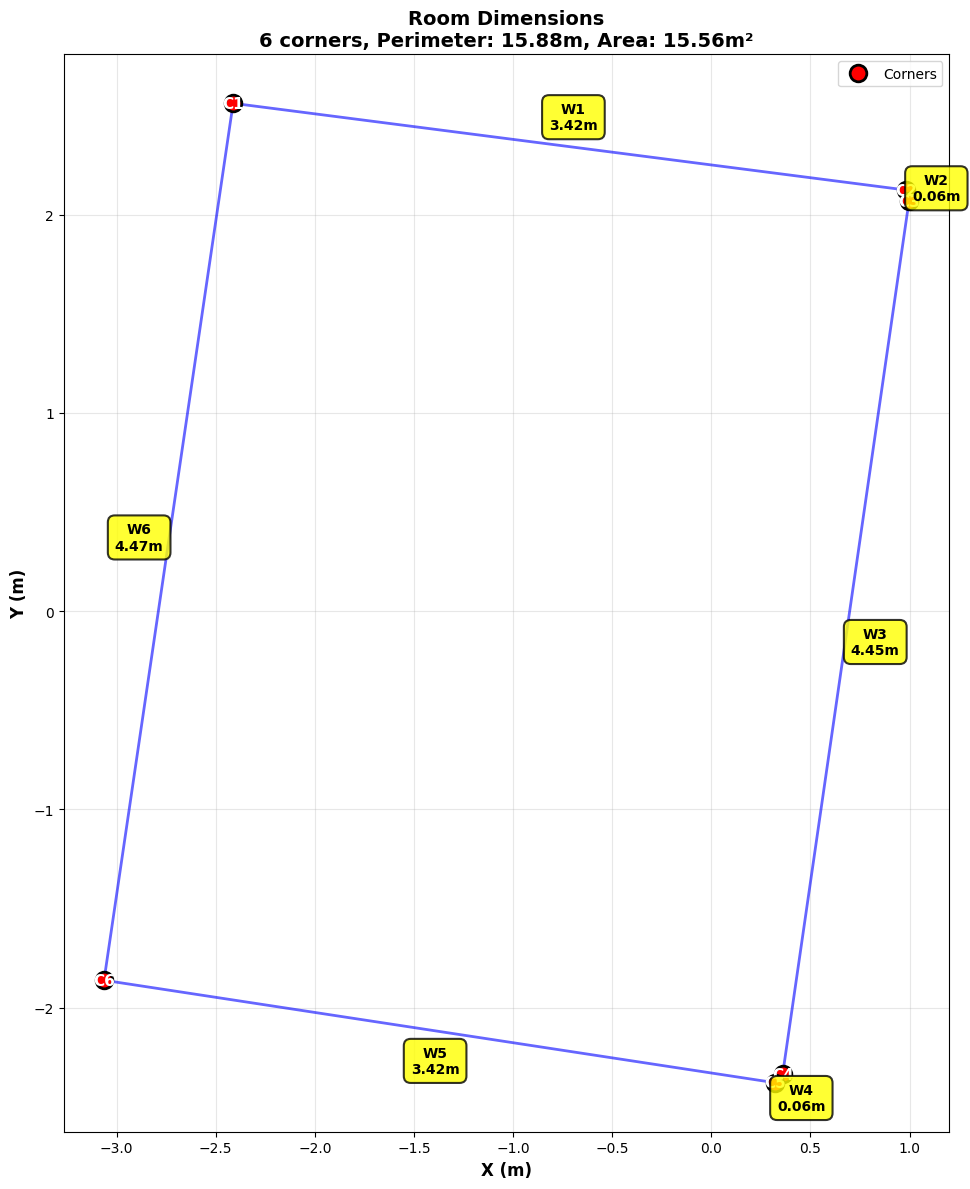

In [43]:
simplified_points = simplify_coords_vw(np.array(offset_implicit.exterior.coords),
                                       epsilon=0.011812495373300667)
dimensions = compute_polygon_dimensions(Polygon(simplified_points))
visualize_polygon_dimensions(Polygon(simplified_points), dimensions)

In [50]:
study, best_params = run_optuna_optimization(
    wall_points_2d=wall_points_2d,
    method='concave_hull',
    median_thickness=median_thickness, 
    ground_truth={'perimeter': p, 'area': S},
    optimize='both',
    split=0.5,
    n_trials=300, 
    timeout=None 
)


BAYESIAN OPTIMIZATION WITH OPTUNA
Optimization: both
Weights: Perimeter=50.0%, Area=50.0%
Ground truth: Perimeter=15.81m, Area=15.34m²
Number of trials: 300


Best trial: 11. Best value: 0.410049: 100%|██████████| 300/300 [00:17<00:00, 16.96it/s]


OPTIMIZATION COMPLETE
Number of finished trials: 300
Number of complete trials: 300


In [51]:
best_params

{'concave_ratio': 0.6912824878709039,
 'simplification': ('vw', 0.011812495373300667)}

In [58]:
merged = distribute_small_segments_proportional_local(dimensions)


PROPORTIONAL LOCAL DISTRIBUTION
Input walls: 7
Min wall length: 0.25m

Found 2 small segment(s):

  Wall 2: 0.093m
    Prev wall 1: 3.391m
    Next wall 3: 4.368m
    Split ratio: 43.7% / 56.3%

  Wall 4: 0.061m
    Prev wall 3: 4.368m
    Next wall 5: 2.828m
    Split ratio: 60.7% / 39.3%

  Distributing Wall 2:
    To prev wall 1: 0.041m
    To next wall 3: 0.037m

  Distributing Wall 4:
    To prev wall 3: 0.037m
    To next wall 5: 0.024m
    Wall 1: 3.391m → 3.393m (+0.002m)
    Wall 3: 4.368m → 4.457m (+0.089m)
    Wall 5: 2.828m → 2.831m (+0.004m)

✓ Result: 7 → 5 walls


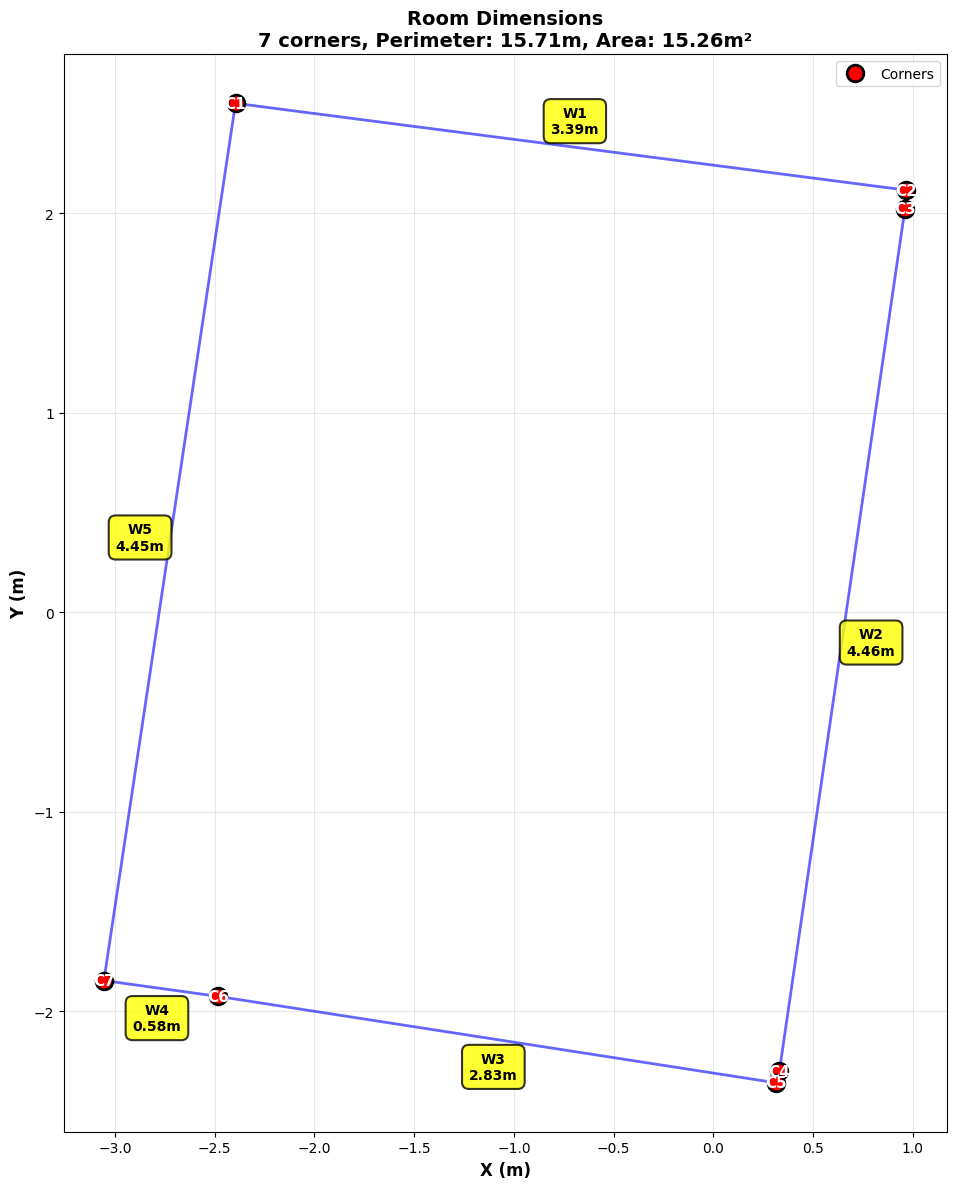

In [59]:
visualize_polygon_dimensions(Polygon(simplified_points), merged)

#### APPROACH 2

In [33]:
merged_walls = merge_to_middle_plane(walls, pairs)


APPROACH B: MERGE TO MIDDLE PLANE

Merging Wall 0 (36,322 pts) + Wall 5 (3,151 pts)
  Middle point: [0.570, -0.640, -0.250]
  Projected 39,473 points to middle plane
  Distance range before: [-0.049, 0.050]
  Distance after: 0 (all on plane)

Merging Wall 1 (34,840 pts) + Wall 4 (2,974 pts)
  Middle point: [-0.764, -2.178, -0.368]
  Projected 37,814 points to middle plane
  Distance range before: [-0.047, 0.034]
  Distance after: 0 (all on plane)

RESULT: 6 → 4 walls
Gap eliminated by projection to middle plane


In [34]:
visualize_each_wall_independetly_3d(merged_walls)

In [63]:
refined_walls = []

for i, wall in enumerate(merged_walls):
    print(f"\n{'#'*70}")
    print(f"WALL {i+1} / {len(merged_walls)}")
    print(f"{'#'*70}")
    
    wall_points = wall['points']
    plane_normal = wall['normal']
    plane_point = wall_points.mean(axis=0)
    
    # Extract THIN inner boundary (1cm thick)
    inner_points, stats = extract_inner_boundary_only(
        wall_points=wall_points,
        plane_normal=plane_normal,
        plane_point=plane_point,
        room_center=room_center,
        boundary_thickness=0.02
    )
    
    refined_walls.append({
        'points': inner_points,
        'normal': plane_normal,
        'statistics': stats
    })
    
    print(f"\nWall {i+1} summary:")
    print(f"  Original thickness: {stats['thickness']*100:.1f}cm")
    print(f"  Extracted layer: {stats['boundary_thickness']*100:.1f}cm")
    print(f"  Points: {len(wall_points):,} → {len(inner_points):,}")
    print(f"  Reduction: {(1 - stats['filter_ratio'])*100:.1f}%")


######################################################################
WALL 1 / 4
######################################################################

EXTRACTING INNER BOUNDARY (THIN LAYER)
Input points: 42,290
Boundary thickness: 2.0cm
  Normal flipped: True
  Wall thickness: 0.0cm
  Distance range: [0.0cm, 0.0cm]
  Innermost surface at: 0.0cm from fitted plane
  Keep points in range: [-2.0cm, 0.0cm]
  Points kept: 42,290 (100.0%)

RESULT: 42,290 → 42,290 points
Reduction: 0.0%


Wall 1 summary:
  Original thickness: 0.0cm
  Extracted layer: 2.0cm
  Points: 42,290 → 42,290
  Reduction: 0.0%

######################################################################
WALL 2 / 4
######################################################################

EXTRACTING INNER BOUNDARY (THIN LAYER)
Input points: 37,159
Boundary thickness: 2.0cm
  Normal flipped: False
  Wall thickness: 0.0cm
  Distance range: [0.0cm, 0.0cm]
  Innermost surface at: 0.0cm from fitted plane
  Keep points in range: [-2

In [64]:
visualize_each_wall_independetly_3d(refined_walls)

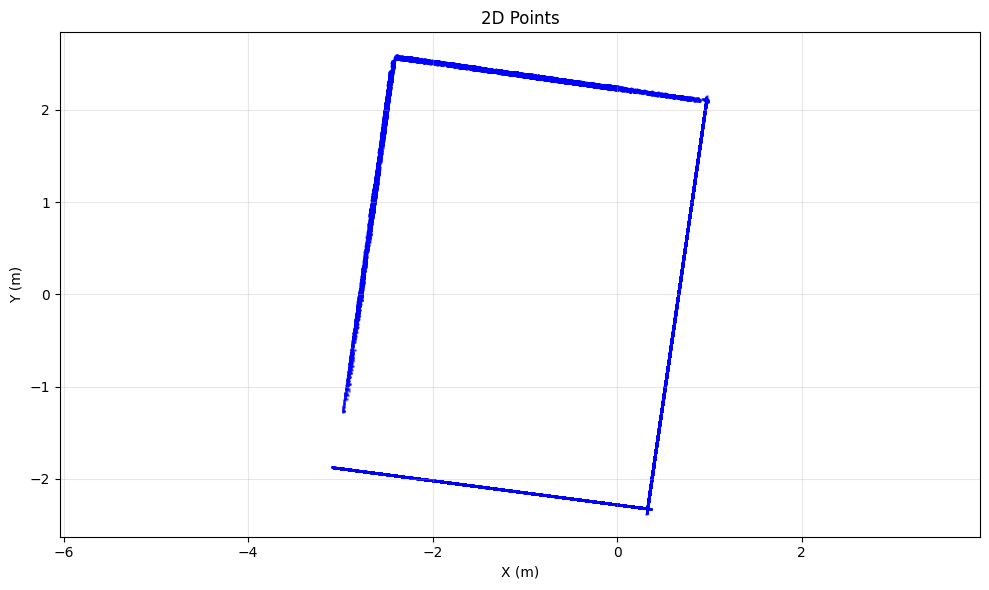

In [35]:
all_wall_points = get_room_wall_points(merged_walls)
wall_points_2d = project_points_to_2d(all_wall_points)
visualize_2d_points(wall_points_2d)

In [36]:
study, best_params = run_optuna_optimization(
    wall_points_2d=wall_points_2d,
    method='concave_hull',
    median_thickness=median_thickness, 
    ground_truth={'perimeter': p, 'area': S},
    optimize='both',
    split=0.5,
    n_trials=100, 
    timeout=None 
)


BAYESIAN OPTIMIZATION WITH OPTUNA
Optimization: both
Weights: Perimeter=50.0%, Area=50.0%
Ground truth: Perimeter=15.81m, Area=15.34m²
Number of trials: 100


Best trial: 72. Best value: 0.916239: 100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


OPTIMIZATION COMPLETE
Number of finished trials: 100
Number of complete trials: 100


In [37]:
best_params

{'concave_ratio': 0.17139145327247815,
 'simplification': ('vw', 0.04079657484302627)}

In [38]:
boundary_polygon = extract_room_boundary_from_walls(
    wall_points_2d,
    method='concave_hull',
    concave_ratio=best_params["concave_ratio"]
)

In [41]:
offset_implicit = offset_boundary_inward(
    boundary_polygon,
    offset_distance=0.01
)


POLYGON DIMENSIONS
Number of corners: 8
Wall  1: Corner 1 → Corner 2, Length:  0.711m, Angle:   79.6°
Wall  2: Corner 2 → Corner 3, Length:  3.706m, Angle:   82.1°
Wall  3: Corner 3 → Corner 4, Length:  0.098m, Angle:   54.3°
Wall  4: Corner 4 → Corner 5, Length:  2.633m, Angle:  352.0°
Wall  5: Corner 5 → Corner 6, Length:  0.748m, Angle:  354.7°
Wall  6: Corner 6 → Corner 7, Length:  4.562m, Angle:  261.8°
Wall  7: Corner 7 → Corner 8, Length:  0.754m, Angle:  168.2°
Wall  8: Corner 8 → Corner 1, Length:  2.680m, Angle:  172.5°

──────────────────────────────────────────────────────────────────────
Total perimeter: 15.891m
Total area:      15.356m²


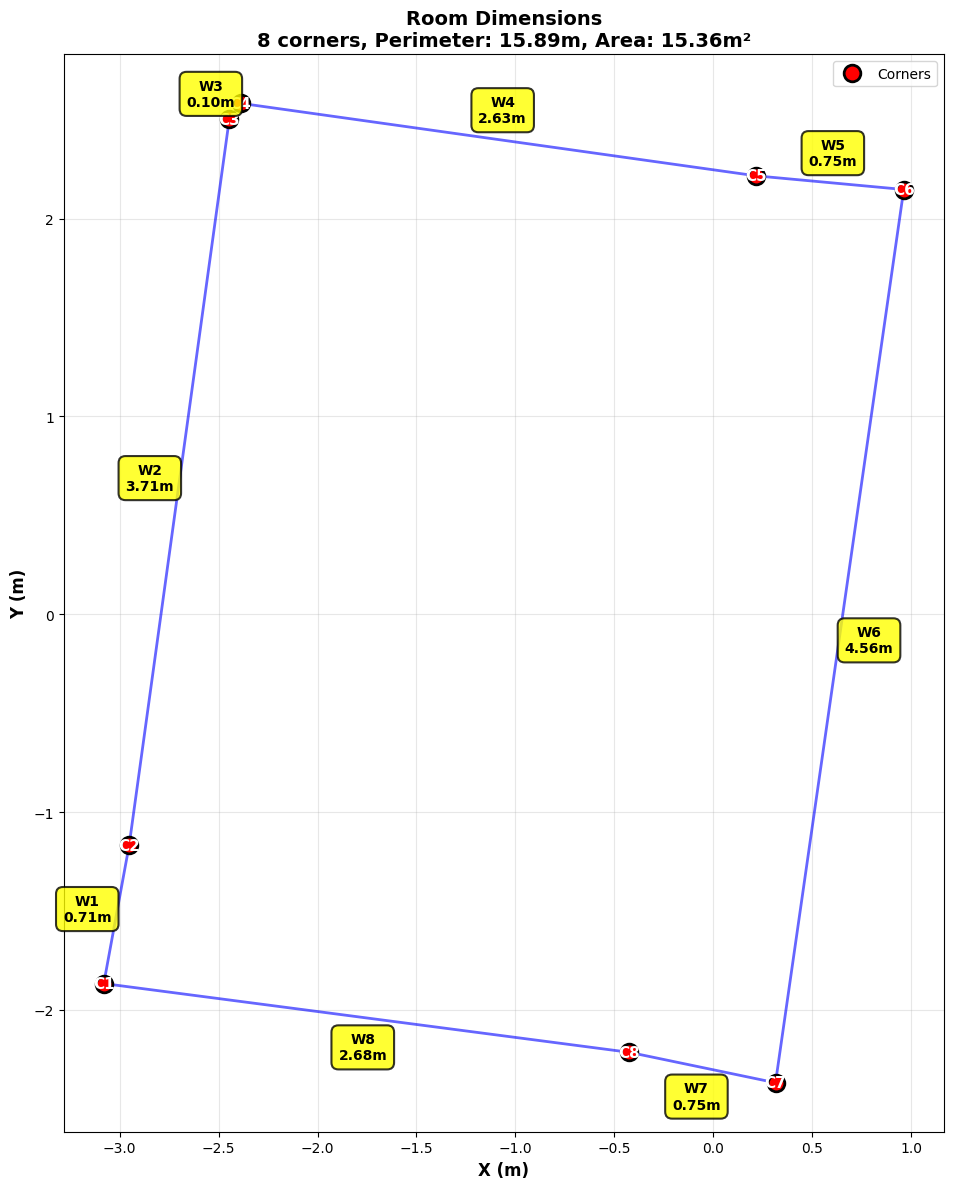

In [42]:
if best_params["simplification"][0] == "dp":
    simplified_boundary = offset_implicit.simplify(best_params["simplification"][1], preserve_topology=True)
    dimensions = compute_polygon_dimensions(simplified_boundary)
    visualize_polygon_dimensions(simplified_boundary, dimensions)
elif best_params["simplification"][0] == "vw":
    simplified_points = simplify_coords_vw(np.array(offset_implicit.exterior.coords),
                                       epsilon=best_params["simplification"][1])
    dimensions = compute_polygon_dimensions(Polygon(simplified_points))
    visualize_polygon_dimensions(Polygon(simplified_points), dimensions)
else:
    dimensions = compute_polygon_dimensions(offset_implicit)
    visualize_polygon_dimensions(offset_implicit, dimensions)

In [45]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(get_room_wall_points(walls))
pcd.paint_uniform_color([0, 1, 0])

PointCloud with 108228 points.

In [46]:
o3d.visualization.draw_geometries([pcd])

In [47]:
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20,
                                                    std_ratio=2.0)

In [48]:
out = pcd.select_by_index(ind, invert=True)
out.paint_uniform_color([1, 0, 0])

PointCloud with 4482 points.

In [50]:
o3d.visualization.draw_geometries([cl, out])

In [62]:
points = np.array(cl.points)

In [63]:
walls = detect_walls_ransac_clustering(
    points,
    floor_height=floor_height,
    ceiling_height=ceiling_height,
    distance_threshold=0.02,      # 3cm RANSAC
    cluster_eps=0.12,             # 12cm clustering
    min_cluster_points=50,       # At least 100 points
    min_wall_height=1.8,          # At least 1.8m tall
    min_wall_length=0.10,         # At least 80cm long
    max_wall_thickness=0.25,      # Max 25cm thick
    min_height_ratio=0.60,        # Must span 60% of room height
    max_iterations=30
)

In [64]:
visualize_each_wall_independetly_3d(walls)

In [65]:
pairs = find_parallel_wall_pairs(walls)

In [66]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.vstack([wall["points"] for wall in walls]))
room_center = pcd.compute_mean_and_covariance()[0]

In [67]:
merged_walls = merge_to_middle_plane(walls, pairs)


APPROACH B: MERGE TO MIDDLE PLANE

RESULT: 4 → 4 walls
Gap eliminated by projection to middle plane


In [68]:
visualize_each_wall_independetly_3d(merged_walls)

In [69]:
refined_walls = []

for i, wall in enumerate(merged_walls):
    print(f"\n{'#'*70}")
    print(f"WALL {i+1} / {len(merged_walls)}")
    print(f"{'#'*70}")
    
    wall_points = wall['points']
    plane_normal = wall['normal']
    plane_point = wall_points.mean(axis=0)
    
    # Extract THIN inner boundary (1cm thick)
    inner_points, stats = extract_inner_boundary_only(
        wall_points=wall_points,
        plane_normal=plane_normal,
        plane_point=plane_point,
        room_center=room_center,
        boundary_thickness=0.02
    )
    
    refined_walls.append({
        'points': inner_points,
        'normal': plane_normal,
        'statistics': stats
    })
    
    print(f"\nWall {i+1} summary:")
    print(f"  Original thickness: {stats['thickness']*100:.1f}cm")
    print(f"  Extracted layer: {stats['boundary_thickness']*100:.1f}cm")
    print(f"  Points: {len(wall_points):,} → {len(inner_points):,}")
    print(f"  Reduction: {(1 - stats['filter_ratio'])*100:.1f}%")


######################################################################
WALL 1 / 4
######################################################################

EXTRACTING INNER BOUNDARY (THIN LAYER)
Input points: 34,087
Boundary thickness: 2.0cm
  Normal flipped: True
  Wall thickness: 4.1cm
  Distance range: [-2.0cm, 2.1cm]
  Innermost surface at: 2.1cm from fitted plane
  Keep points in range: [0.1cm, 2.1cm]
  Points kept: 16,836 (49.4%)

RESULT: 34,087 → 16,836 points
Reduction: 50.6%


Wall 1 summary:
  Original thickness: 4.1cm
  Extracted layer: 2.0cm
  Points: 34,087 → 16,836
  Reduction: 50.6%

######################################################################
WALL 2 / 4
######################################################################

EXTRACTING INNER BOUNDARY (THIN LAYER)
Input points: 33,472
Boundary thickness: 2.0cm
  Normal flipped: False
  Wall thickness: 4.7cm
  Distance range: [-2.5cm, 2.3cm]
  Innermost surface at: 2.3cm from fitted plane
  Keep points in range: [

In [79]:
visualize_each_wall_independetly_3d(merged_walls)


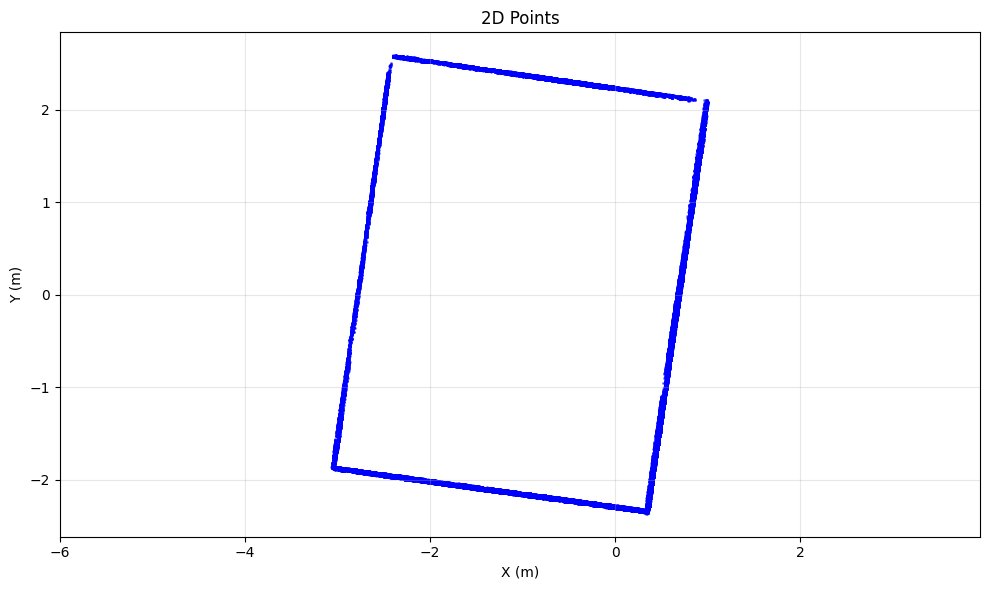

In [80]:
all_wall_points = get_room_wall_points(merged_walls)
wall_points_2d = project_points_to_2d(all_wall_points)
visualize_2d_points(wall_points_2d)

In [87]:
study, best_params = run_optuna_optimization(
    wall_points_2d=wall_points_2d,
    method='concave_hull',
    median_thickness=0.02, 
    ground_truth={'perimeter': p, 'area': S},
    optimize='both',
    split=0.5,
    n_trials=100, 
    timeout=None 
)


BAYESIAN OPTIMIZATION WITH OPTUNA
Optimization: both
Weights: Perimeter=50.0%, Area=50.0%
Ground truth: Perimeter=15.81m, Area=15.34m²
Number of trials: 100


Best trial: 23. Best value: 0.118745: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


OPTIMIZATION COMPLETE
Number of finished trials: 100
Number of complete trials: 100


In [88]:
best_params, median_thickness

({'concave_ratio': 0.3355680373722018,
  'simplification': ('dp', 0.018249737416292145)},
 0.0)

In [90]:
boundary_polygon = extract_room_boundary_from_walls(
    wall_points_2d,
    method='concave_hull',
    concave_ratio=0.3355680373722018
)

In [91]:
offset_implicit = offset_boundary_inward(
    boundary_polygon,
    offset_distance=0.02
)

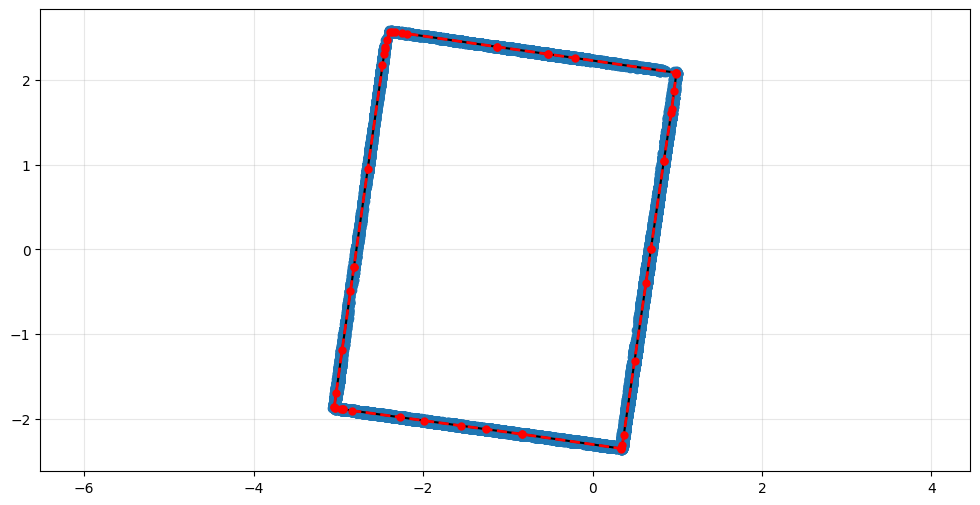

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(wall_points_2d[:, 0], wall_points_2d[:, 1], 'o')

if offset_implicit.geom_type == 'Polygon':
    # get boundary coordinates
    x, y = offset_implicit.exterior.xy
    coords = np.array(list(zip(x, y)))
    for i in range(len(coords) - 1):
        plt.plot([coords[i, 0], coords[i+1, 0]], 
                [coords[i, 1], coords[i+1, 1]], 'k-')
    plt.plot(x, y, 'r--', lw=2, marker='o', markersize=5)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()


POLYGON DIMENSIONS
Number of corners: 5
Wall  1: Corner 1 → Corner 2, Length:  4.209m, Angle:   82.0°
Wall  2: Corner 2 → Corner 3, Length:  0.267m, Angle:   74.8°
Wall  3: Corner 3 → Corner 4, Length:  3.404m, Angle:  351.9°
Wall  4: Corner 4 → Corner 5, Length:  4.482m, Angle:  261.7°
Wall  5: Corner 5 → Corner 1, Length:  3.421m, Angle:  171.8°

──────────────────────────────────────────────────────────────────────
Total perimeter: 15.782m
Total area:      15.350m²


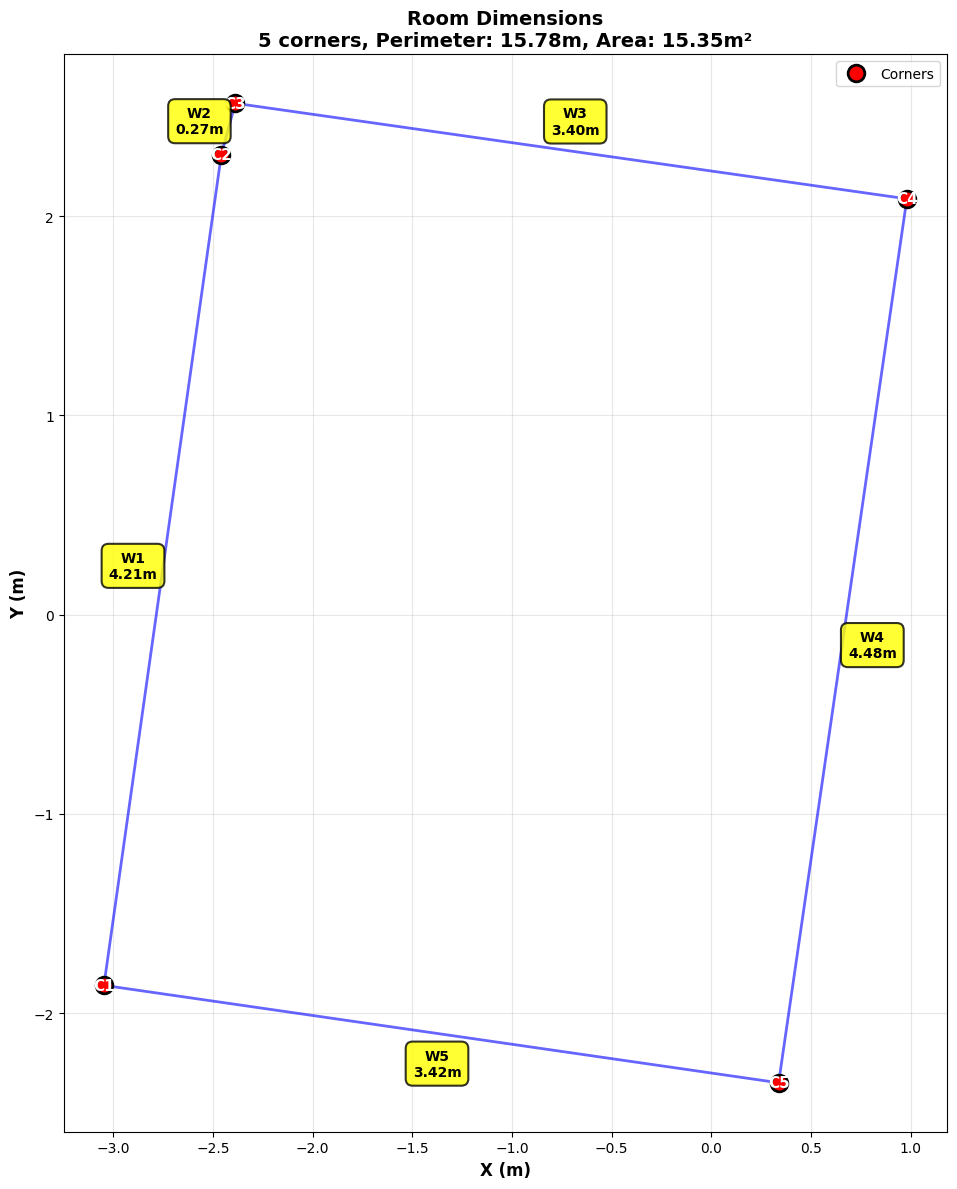

In [93]:
if best_params["simplification"][0] == "dp":
    simplified_boundary = offset_implicit.simplify(best_params["simplification"][1], preserve_topology=True)
    dimensions = compute_polygon_dimensions(simplified_boundary)
    visualize_polygon_dimensions(simplified_boundary, dimensions)
elif best_params["simplification"][0] == "vw":
    simplified_points = simplify_coords_vw(np.array(offset_implicit.exterior.coords),
                                       epsilon=best_params["simplification"][1])
    dimensions = compute_polygon_dimensions(Polygon(simplified_points))
    visualize_polygon_dimensions(Polygon(simplified_points), dimensions)
else:
    dimensions = compute_polygon_dimensions(offset_implicit)
    visualize_polygon_dimensions(offset_implicit, dimensions)


POLYGON DIMENSIONS
Number of corners: 4
Wall  1: Corner 1 → Corner 2, Length:  3.424m, Angle:  352.3°
Wall  2: Corner 2 → Corner 3, Length:  4.502m, Angle:  261.9°
Wall  3: Corner 3 → Corner 4, Length:  3.452m, Angle:  171.9°
Wall  4: Corner 4 → Corner 1, Length:  4.479m, Angle:   81.6°

──────────────────────────────────────────────────────────────────────
Total perimeter: 15.856m
Total area:      15.437m²


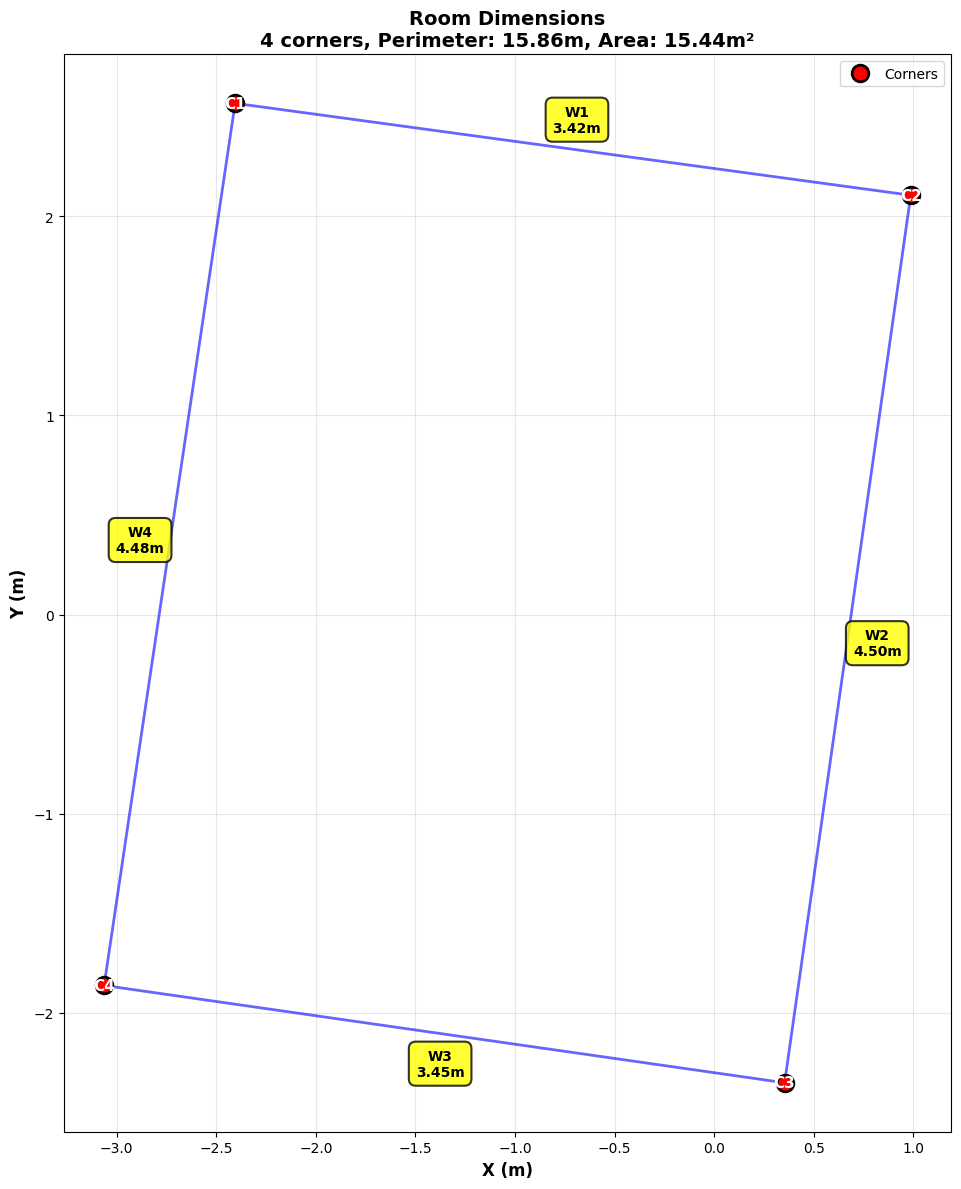

In [77]:
if best_params["simplification"][0] == "dp":
    simplified_boundary = offset_implicit.simplify(best_params["simplification"][1], preserve_topology=True)
    dimensions = compute_polygon_dimensions(simplified_boundary)
    visualize_polygon_dimensions(simplified_boundary, dimensions)
elif best_params["simplification"][0] == "vw":
    simplified_points = simplify_coords_vw(np.array(offset_implicit.exterior.coords),
                                       epsilon=best_params["simplification"][1])
    dimensions = compute_polygon_dimensions(Polygon(simplified_points))
    visualize_polygon_dimensions(Polygon(simplified_points), dimensions)
else:
    dimensions = compute_polygon_dimensions(offset_implicit)
    visualize_polygon_dimensions(offset_implicit, dimensions)

In [108]:
print("Checking all wall pairs:")

for i in range(len(walls)):
    for j in range(i+1, len(walls)):
        normal_i = walls[i]['normal'][:2]
        normal_j = walls[j]['normal'][:2]
        
        angle = np.degrees(np.arccos(np.clip(np.abs(np.dot(normal_i, normal_j)), 0, 1)))
        
        if angle < 5:
            centroid_i = walls[i]['points'].mean(axis=0)
            centroid_j = walls[j]['points'].mean(axis=0)
            dist = np.linalg.norm(centroid_j - centroid_i)
            
            print(f"\nWall {i} ↔ Wall {j}:")
            print(f"  Angle: {angle:.2f}°")
            print(f"  Distance: {dist:.3f}m")
            print(f"  → {'PAIR!' if dist < 0.3 else 'Opposite sides'}")

Checking all wall pairs:

Wall 0 ↔ Wall 3:
  Angle: 0.83°
  Distance: 3.486m
  → Opposite sides

Wall 0 ↔ Wall 4:
  Angle: 1.26°
  Distance: 0.927m
  → Opposite sides

Wall 1 ↔ Wall 2:
  Angle: 0.35°
  Distance: 4.500m
  → Opposite sides

Wall 3 ↔ Wall 4:
  Angle: 1.00°
  Distance: 3.712m
  → Opposite sides


In [109]:
for i, wall in enumerate(walls):
    angle = np.degrees(np.arctan2(wall['normal'][1], wall['normal'][0]))
    print(f"Wall {i}: angle={angle:.1f}°, points={len(wall['points']):,}")

Wall 0: angle=-8.4°, points=37,219
Wall 1: angle=82.0°, points=34,670
Wall 2: angle=81.9°, points=23,647
Wall 3: angle=-8.0°, points=14,376
Wall 4: angle=-7.9°, points=1,815


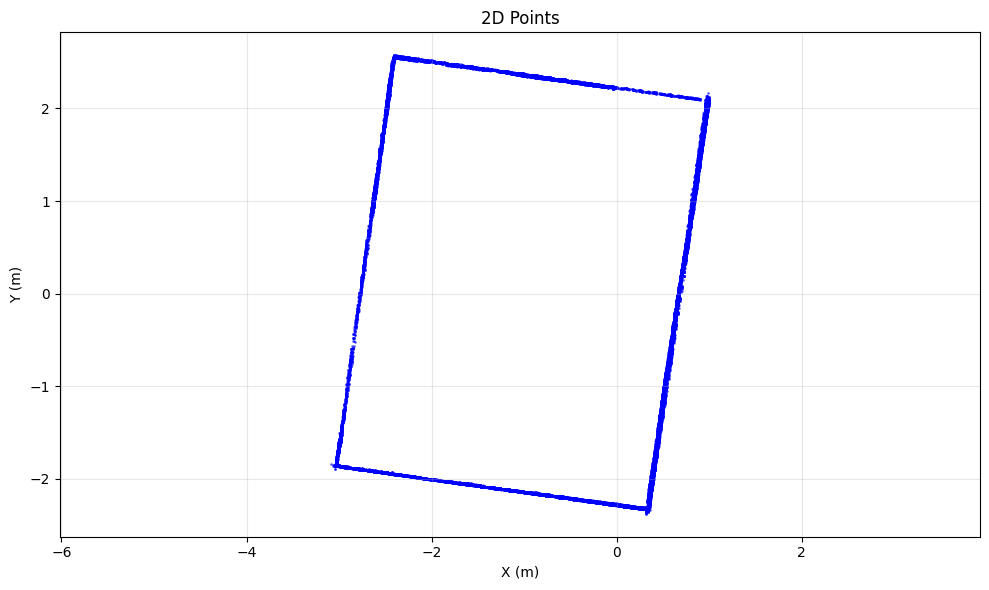

In [107]:
visualize_2d_points(np.vstack([wall["points"] for wall in refined_walls])[:, : 2])

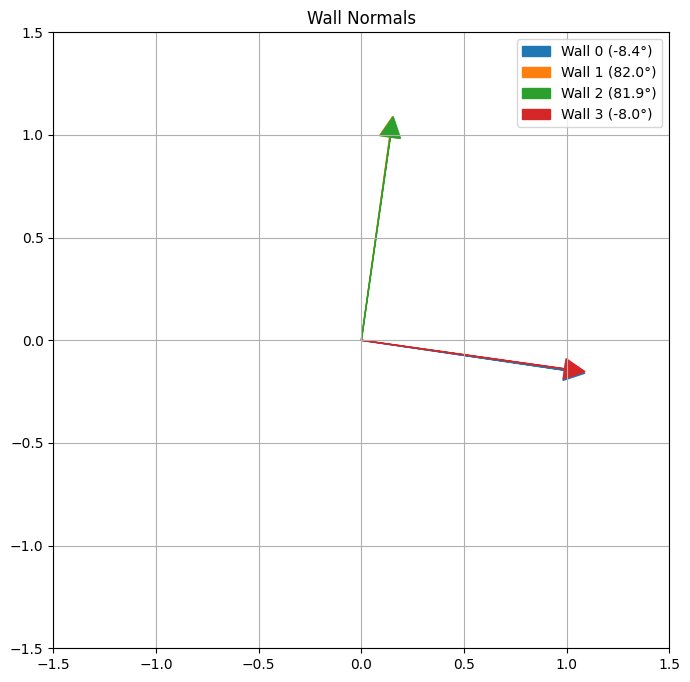

In [105]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

for i, wall in enumerate(refined_walls):
    normal = wall['normal'][:2]
    angle = np.degrees(np.arctan2(normal[1], normal[0]))
    
    # Draw normal as arrow
    ax.arrow(0, 0, normal[0], normal[1], 
            head_width=0.1, head_length=0.1, 
            fc=f'C{i}', ec=f'C{i}', label=f'Wall {i} ({angle:.1f}°)')
    
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
ax.set_title('Wall Normals')
plt.show()


In [103]:
import numpy as np

def plane_to_2d_line(wall):
    """
    Convert 3D wall plane to 2D line equation
    
    3D plane: normal · (point - plane_point) = 0
    2D line: a*x + b*y + c = 0
    
    Parameters:
    -----------
    wall : dict
        Wall with 'normal' and 'points' (or 'plane_point')
    
    Returns:
    --------
    line_2d : np.ndarray [a, b, c]
        2D line equation coefficients
    """
    
    normal = wall['normal']
    
    # Get a point on the plane (use centroid if no plane_point)
    if 'plane_point' in wall:
        plane_point = wall['plane_point']
    else:
        plane_point = wall['points'].mean(axis=0)
    
    # 2D projection (ignore Z)
    # Line: nx*x + ny*y + c = 0
    # Where: c = -(nx*px + ny*py)
    
    a = normal[0]
    b = normal[1]
    plane_point_2d = plane_point[:2]
    c = -np.dot([a, b], plane_point_2d)
    
    line_2d = np.array([a, b, c])
    
    return line_2d


def order_walls_by_angle(walls):
    """
    Order walls spatially by their normal angles
    
    This ensures walls form a closed loop around the room
    
    Parameters:
    -----------
    walls : list of dict
        Walls with 'normal' field
    
    Returns:
    --------
    walls_ordered : list of dict
        Walls in spatial order (clockwise or counter-clockwise)
    order_indices : list of int
        Original indices of ordered walls
    """
    
    print(f"\n{'='*70}")
    print(f"ORDERING WALLS BY NORMAL ANGLE")
    print(f"{'='*70}")
    
    # Calculate angle of each wall's normal (in X-Y plane)
    angles = []
    for i, wall in enumerate(walls):
        normal_2d = wall['normal'][:2]  # Just X, Y components
        angle = np.arctan2(normal_2d[1], normal_2d[0])
        angle_deg = np.degrees(angle)
        
        angles.append(angle)
        
        print(f"Wall {i}: normal=[{normal_2d[0]:6.3f}, {normal_2d[1]:6.3f}], angle={angle_deg:6.1f}°")
    
    # Sort by angle
    order_indices = np.argsort(angles)
    walls_ordered = [walls[i] for i in order_indices]
    
    print(f"\nOrdered sequence: {list(order_indices)}")
    
    return walls_ordered, list(order_indices)


def intersect_2d_lines(line1, line2):
    """
    Find intersection of two 2D lines
    
    line1: [a1, b1, c1] represents a1*x + b1*y + c1 = 0
    line2: [a2, b2, c2] represents a2*x + b2*y + c2 = 0
    
    Returns:
    --------
    intersection : np.ndarray [x, y] or None if parallel
    """
    
    a1, b1, c1 = line1
    a2, b2, c2 = line2
    
    # Determinant (cross product of normals)
    det = a1*b2 - a2*b1
    
    if abs(det) < 1e-10:
        # Lines are parallel (shouldn't happen for rectangle)
        print(f"  ⚠️  Warning: Lines are parallel! det={det}")
        return None
    
    # Cramer's rule
    x = (b1*c2 - b2*c1) / det
    y = (a2*c1 - a1*c2) / det
    
    return np.array([x, y])


def calculate_rectangle_from_planes(walls, room_center=None):
    """
    Extract rectangle dimensions from wall plane equations
    
    Strategy:
    1. Convert 3D planes to 2D lines
    2. Order walls spatially
    3. Find line intersections = corners
    4. Calculate dimensions
    5. Validate rectangle
    
    Parameters:
    -----------
    walls : list of dict
        4 walls with 'normal' and 'points'
    room_center : np.ndarray, optional
        Room center for reference
    
    Returns:
    --------
    rectangle : dict
        Contains corners, dimensions, angles, etc.
    """
    
    print(f"\n{'='*70}")
    print(f"RECTANGLE DETECTION FROM PLANE EQUATIONS")
    print(f"{'='*70}")
    print(f"Input walls: {len(walls)}")
    
    if len(walls) != 4:
        print(f"⚠️  Warning: Expected 4 walls, got {len(walls)}")
        print(f"   Rectangle detection works best with exactly 4 walls")
    
    # Step 1: Order walls spatially
    walls_ordered, order_indices = order_walls_by_angle(walls)
    
    # Step 2: Convert each plane to 2D line
    print(f"\n{'='*70}")
    print(f"CONVERTING PLANES TO 2D LINES")
    print(f"{'='*70}")
    
    lines = []
    for i, wall in enumerate(walls_ordered):
        line = plane_to_2d_line(wall)
        lines.append(line)
        
        print(f"Wall {i}: Line equation: {line[0]:.4f}*x + {line[1]:.4f}*y + {line[2]:.4f} = 0")
    
    # Step 3: Find intersections (corners)
    print(f"\n{'='*70}")
    print(f"FINDING CORNERS (LINE INTERSECTIONS)")
    print(f"{'='*70}")
    
    corners = []
    for i in range(len(lines)):
        line_curr = lines[i]
        line_next = lines[(i + 1) % len(lines)]
        
        corner = intersect_2d_lines(line_curr, line_next)
        
        if corner is None:
            print(f"⚠️  Failed to find intersection between Wall {i} and Wall {(i+1)%len(lines)}")
            return None
        
        corners.append(corner)
        
        print(f"Corner {i}: [{corner[0]:7.3f}, {corner[1]:7.3f}] (Wall {i} ∩ Wall {(i+1)%len(lines)})")
    
    corners = np.array(corners)
    
    # Step 4: Calculate edge lengths
    print(f"\n{'='*70}")
    print(f"CALCULATING DIMENSIONS")
    print(f"{'='*70}")
    
    edges = []
    for i in range(len(corners)):
        corner_curr = corners[i]
        corner_next = corners[(i + 1) % len(corners)]
        
        edge_length = np.linalg.norm(corner_next - corner_curr)
        edges.append(edge_length)
        
        print(f"Edge {i}: {edge_length:.3f}m (Corner {i} → Corner {(i+1)%len(corners)})")
    
    # For rectangle, opposite edges should be equal
    # edges[0] and edges[2] are opposite
    # edges[1] and edges[3] are opposite
    
    if len(edges) == 4:
        width = (edges[0] + edges[2]) / 2
        height = (edges[1] + edges[3]) / 2
        
        print(f"\nDimensions:")
        print(f"  Width:  {width:.3f}m (average of edges 0 and 2)")
        print(f"  Height: {height:.3f}m (average of edges 1 and 3)")
    else:
        # Non-rectangular, just report all edges
        width = max(edges)
        height = min(edges)
        print(f"\n⚠️  Non-standard shape")
        print(f"  Max edge: {width:.3f}m")
        print(f"  Min edge: {height:.3f}m")
    
    perimeter = sum(edges)
    area = width * height if len(edges) == 4 else 0
    
    print(f"  Perimeter: {perimeter:.3f}m")
    print(f"  Area: {area:.3f}m²")
    
    # Step 5: Calculate angles (validate rectangle)
    print(f"\n{'='*70}")
    print(f"VALIDATING RECTANGLE (CORNER ANGLES)")
    print(f"{'='*70}")
    
    angles = []
    for i in range(len(corners)):
        corner_prev = corners[(i - 1) % len(corners)]
        corner_curr = corners[i]
        corner_next = corners[(i + 1) % len(corners)]
        
        # Vectors from current corner to neighbors
        v1 = corner_prev - corner_curr
        v2 = corner_next - corner_curr
        
        # Angle between vectors
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        angle = np.degrees(np.arccos(np.clip(cos_angle, -1, 1)))
        
        angles.append(angle)
        
        deviation = abs(angle - 90)
        status = "✓" if deviation < 5 else "⚠️"
        
        print(f"Corner {i}: {angle:.2f}° (deviation: {deviation:.2f}°) {status}")
    
    # Validation
    all_near_90 = all(85 < angle < 95 for angle in angles)
    
    if all_near_90:
        print(f"\n✓ Valid rectangle! All angles ≈ 90°")
    else:
        print(f"\n⚠️  Not a perfect rectangle (angles deviate from 90°)")
    
    # Build result
    rectangle = {
        'corners': corners,
        'edges': edges,
        'width': width,
        'height': height,
        'perimeter': perimeter,
        'area': area,
        'angles': angles,
        'is_valid_rectangle': all_near_90,
        'wall_order': order_indices,
        'lines': lines
    }
    
    print(f"\n{'='*70}")
    print(f"RECTANGLE DETECTION COMPLETE")
    print(f"{'='*70}")
    print(f"Corners: {len(corners)}")
    print(f"Dimensions: {width:.3f}m × {height:.3f}m")
    print(f"Perimeter: {perimeter:.3f}m")
    print(f"Area: {area:.3f}m²")
    print(f"Valid rectangle: {all_near_90}")
    
    return rectangle

def visualize_rectangle(rectangle, walls=None):
    """
    Visualize detected rectangle
    """
    
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot corners
    corners = rectangle['corners']
    
    # Close the rectangle
    corners_closed = np.vstack([corners, corners[0]])
    
    ax.plot(corners_closed[:, 0], corners_closed[:, 1], 
            'b-', linewidth=2, label='Rectangle')
    
    # Plot corner points
    ax.scatter(corners[:, 0], corners[:, 1], 
              c='red', s=100, zorder=5, label='Corners')
    
    # Label corners
    for i, corner in enumerate(corners):
        ax.text(corner[0], corner[1], f'  {i}', 
               fontsize=12, ha='left', va='bottom')
    
    # Plot wall lines (extended)
    if 'lines' in rectangle:
        for i, line in enumerate(rectangle['lines']):
            a, b, c = line
            
            # Generate points along the line
            if abs(b) > 1e-10:
                x = np.linspace(corners[:, 0].min() - 1, corners[:, 0].max() + 1, 100)
                y = -(a*x + c) / b
            else:
                y = np.linspace(corners[:, 1].min() - 1, corners[:, 1].max() + 1, 100)
                x = -c / a * np.ones_like(y)
            
            ax.plot(x, y, '--', alpha=0.3, label=f'Wall {i} line')
    
    # Optionally plot original wall points
    if walls is not None:
        for i, wall in enumerate(walls):
            points_2d = wall['points'][:, :2]
            ax.scatter(points_2d[:, 0], points_2d[:, 1], 
                      s=1, alpha=0.3, label=f'Wall {i} points')
    
    # Labels
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(f"Rectangle: {rectangle['width']:.2f}m × {rectangle['height']:.2f}m\n"
                f"Perimeter: {rectangle['perimeter']:.2f}m, Area: {rectangle['area']:.2f}m²")
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# USAGE
# ============================================================================

# Apply to your walls (after merging and extracting inner surface)
rectangle = calculate_rectangle_from_planes(refined_walls, room_center)

# Access results
print(f"\n📐 Final Results:")
print(f"Width: {rectangle['width']:.3f}m")
print(f"Height: {rectangle['height']:.3f}m")
print(f"Perimeter: {rectangle['perimeter']:.3f}m")
print(f"Area: {rectangle['area']:.3f}m²")
print(f"\nCorners:")
for i, corner in enumerate(rectangle['corners']):
    print(f"  {i}: [{corner[0]:7.3f}, {corner[1]:7.3f}]")


RECTANGLE DETECTION FROM PLANE EQUATIONS
Input walls: 4

ORDERING WALLS BY NORMAL ANGLE
Wall 0: normal=[ 0.989, -0.146], angle=  -8.4°
Wall 1: normal=[ 0.138,  0.990], angle=  82.0°
Wall 2: normal=[ 0.141,  0.990], angle=  81.9°
Wall 3: normal=[ 0.990, -0.139], angle=  -8.0°

Ordered sequence: [np.int64(0), np.int64(3), np.int64(2), np.int64(1)]

CONVERTING PLANES TO 2D LINES
Wall 0: Line equation: 0.9892*x + -0.1459*y + -0.6681 = 0
Wall 1: Line equation: 0.9903*x + -0.1390*y + 2.7442 = 0
Wall 2: Line equation: 0.1410*x + 0.9900*y + -2.1998 = 0
Wall 3: Line equation: 0.1385*x + 0.9904*y + 2.2636 = 0

FINDING CORNERS (LINE INTERSECTIONS)
Corner 0: [-70.555, -482.889] (Wall 0 ∩ Wall 1)
Corner 1: [ -2.411,   2.565] (Wall 1 ∩ Wall 2)
Corner 2: [1716.427, -242.258] (Wall 2 ∩ Wall 3)
Corner 3: [  0.331,  -2.332] (Wall 3 ∩ Wall 0)

CALCULATING DIMENSIONS
Edge 0: 490.213m (Corner 0 → Corner 1)
Edge 1: 1736.186m (Corner 1 → Corner 2)
Edge 2: 1732.787m (Corner 2 → Corner 3)
Edge 3: 485.757m (Co


RECTANGLE DETECTION FROM PLANE EQUATIONS
Input walls: 4

ORDERING WALLS BY NORMAL ANGLE
Wall 0: normal=[ 0.989, -0.146], angle=  -8.4°
Wall 1: normal=[ 0.138,  0.990], angle=  82.0°
Wall 2: normal=[ 0.141,  0.990], angle=  81.9°
Wall 3: normal=[ 0.990, -0.139], angle=  -8.0°

Ordered sequence: [np.int64(0), np.int64(3), np.int64(2), np.int64(1)]

CONVERTING PLANES TO 2D LINES
Wall 0: Line equation: 0.9892*x + -0.1459*y + -0.6791 = 0
Wall 1: Line equation: 0.9903*x + -0.1390*y + 2.7571 = 0
Wall 2: Line equation: 0.1410*x + 0.9900*y + -2.2123 = 0
Wall 3: Line equation: 0.1385*x + 0.9904*y + 2.2737 = 0

FINDING CORNERS (LINE INTERSECTIONS)
Corner 0: [-71.043, -486.275] (Wall 0 ∩ Wall 1)
Corner 1: [ -2.422,   2.580] (Wall 1 ∩ Wall 2)
Corner 2: [1725.148, -243.488] (Wall 2 ∩ Wall 3)
Corner 3: [  0.341,  -2.344] (Wall 3 ∩ Wall 0)

CALCULATING DIMENSIONS
Edge 0: 493.647m (Corner 0 → Corner 1)
Edge 1: 1745.007m (Corner 1 → Corner 2)
Edge 2: 1741.583m (Corner 2 → Corner 3)
Edge 3: 489.168m (Co

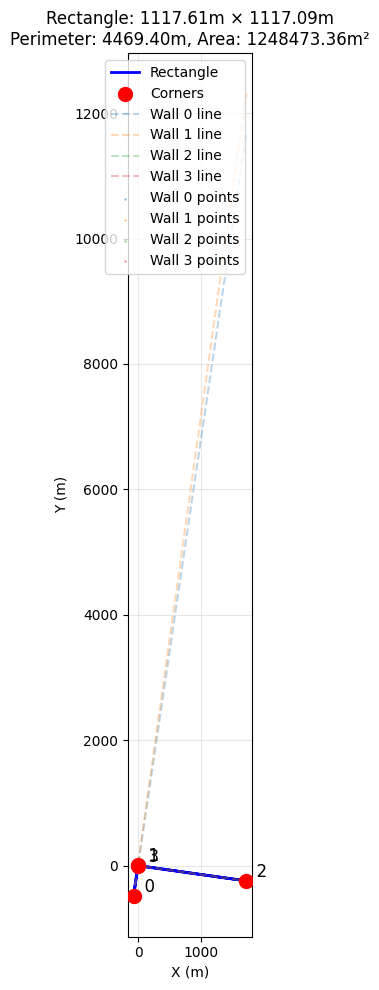

In [104]:
rectangle = calculate_rectangle_from_planes(merged_walls, room_center)
visualize_rectangle(rectangle, walls=merged_walls)

### pointnet

In [16]:
predictions = sem_seg.pointnet_segmentation(sem_seg.points, type='all')

In [17]:
sem_seg.visualize_segments(predictions)

PointCloud with 891428 points.

In [20]:
sem_seg.classes["ceiling"]

0

In [21]:
ceiling_mask = predictions == sem_seg.classes["ceiling"]
wall_mask = predictions == sem_seg.classes["wall"]
door_mask = predictions == sem_seg.classes["door"]
window_mask = predictions == sem_seg.classes["window"]

ceiling_points_2d = points_2d[ceiling_mask]
wall_points_2d = points_2d[wall_mask]
door_points_2d = points_2d[door_mask]
window_points_2d = points_2d[window_mask]

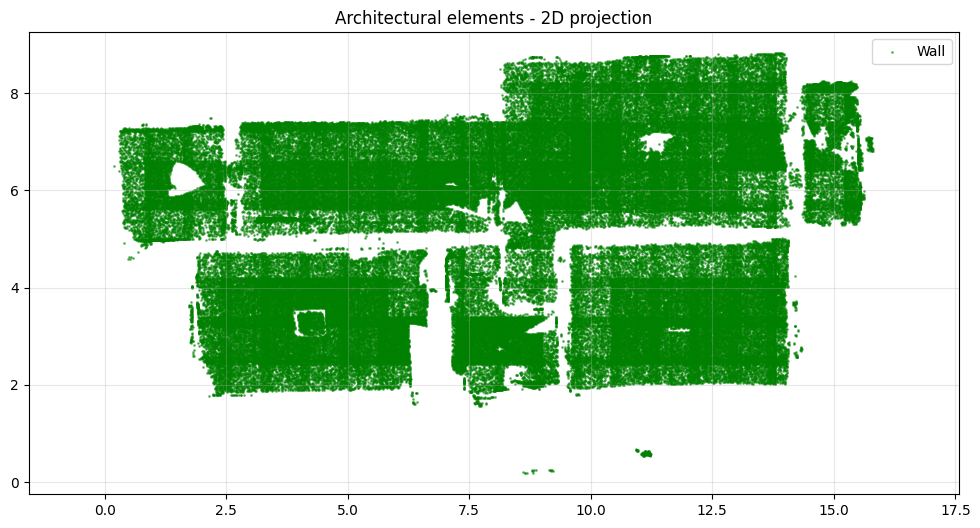

In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1, label='Wall', alpha=0.5)
# plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [116]:
clustering = DBSCAN(eps=0.1, min_samples=5, n_jobs=-1)  
ceiling_clusters = clustering.fit_predict(ceiling_points_2d)

In [121]:
n = len(set(ceiling_clusters)) - (1 if -1 in ceiling_clusters else 0)
print(f"Number of segments found: {n}")

Number of segments found: 16


In [122]:
ceiling_clusters

array([0, 0, 0, ..., 1, 1, 1], shape=(124351,))

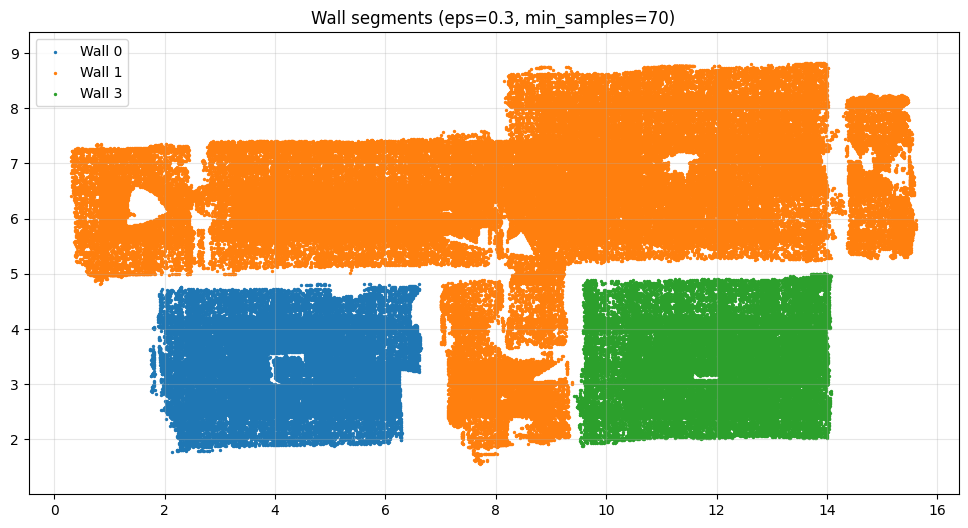

In [133]:
keep_clusters = []
plt.figure(figsize=(12, 6))
for cluster_id in set(ceiling_clusters):
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        label = f'Wall {cluster_id}'
        color = None
    
    mask = ceiling_clusters == cluster_id
    if sum(mask) > 300:
        keep_clusters.append(cluster_id)
        plt.scatter(ceiling_points_2d[mask, 0], ceiling_points_2d[mask, 1], 
                    s=2, label=label, c=color if color else None)

plt.axis('equal')
plt.legend()
plt.title(f'Wall segments (eps=0.3, min_samples=70)')
plt.grid(True, alpha=0.3)
plt.show()

In [134]:
keep_clusters

[np.int64(0), np.int64(1), np.int64(3)]

In [146]:
mask = ceiling_clusters == keep_clusters[0]

In [147]:
sum(mask)

np.int64(22783)

In [148]:
coord = ceiling_points_2d[mask]

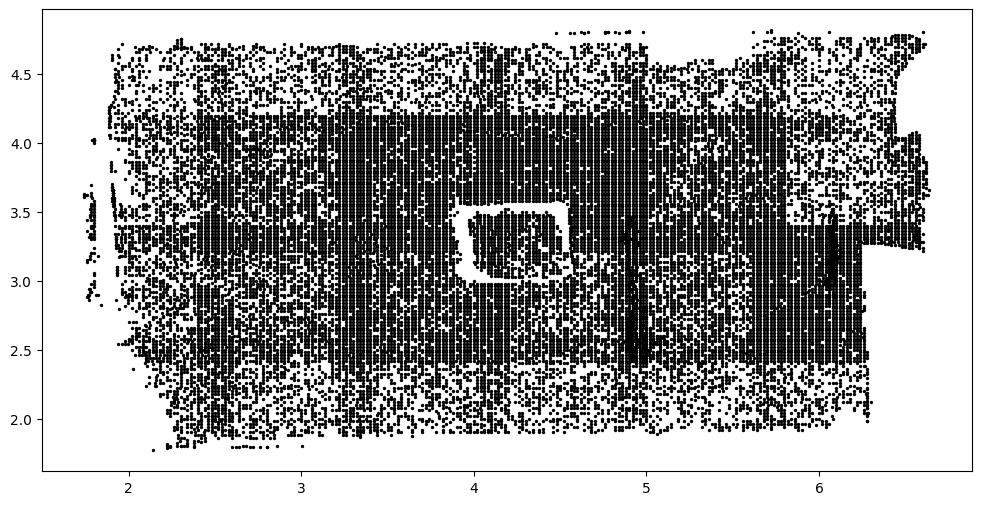

In [149]:
plt.figure(figsize=(12, 6))
plt.scatter(coord[:, 0], coord[:, 1], 
                    s=2, label=label, c=color if color else None)

In [144]:
def get_shape_dimensions_numpy(coordinates_array):
    if coordinates_array.size == 0:
        return 0, 0

    min_coords = np.min(coordinates_array, axis=0)
    max_coords = np.max(coordinates_array, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

In [145]:
get_shape_dimensions_numpy(coord)

(np.float64(4.670390605926514), np.float64(3.1399996876716614))

In [131]:
sum(mask)

np.int64(38)

In [ ]:
wall_indices = sem_seg.ransac_segmentor.segments['wall_pointnet']['indices']
# door_indices = sem_seg.ransac_segmentor.segments['door_pointnet']['indices']
# window_indices = sem_seg.ransac_segmentor.segments['window_pointnet']['indices']

print(f"Wall points: {len(wall_indices)}")
# print(f"Door points: {len(door_indices)}")
# print(f"Window points: {len(window_indices)}")

  

# Extract architectural points using indices
wall_points_2d = points_2d[wall_indices]
# door_points_2d = points_2d[door_indices]
# window_points_2d = points_2d[window_indices]

Wall points: 165476


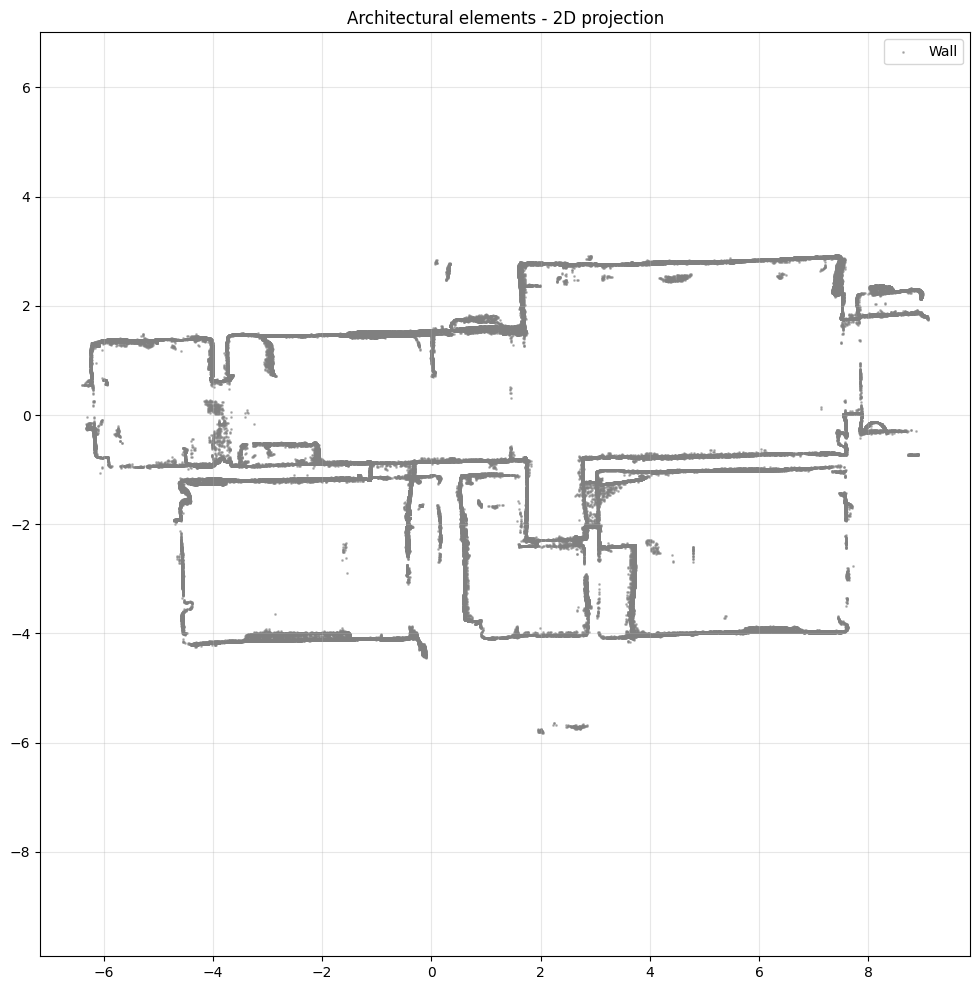

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [12]:
door_clusters = sem_seg.ransac_segmentor.cluster_points(door_indices, eps=0.5, )

In [13]:
for i, cluster in enumerate(door_clusters):
    print(i, len(cluster))

0 326
1 15
2 5062
3 12


In [14]:
door_indices_clustered = door_clusters[2]

In [15]:
wall_points_2d = points_2d[wall_indices]
door_points_2d = points_2d[door_indices_clustered]
# window_points_2d = points_2d[window_indices]

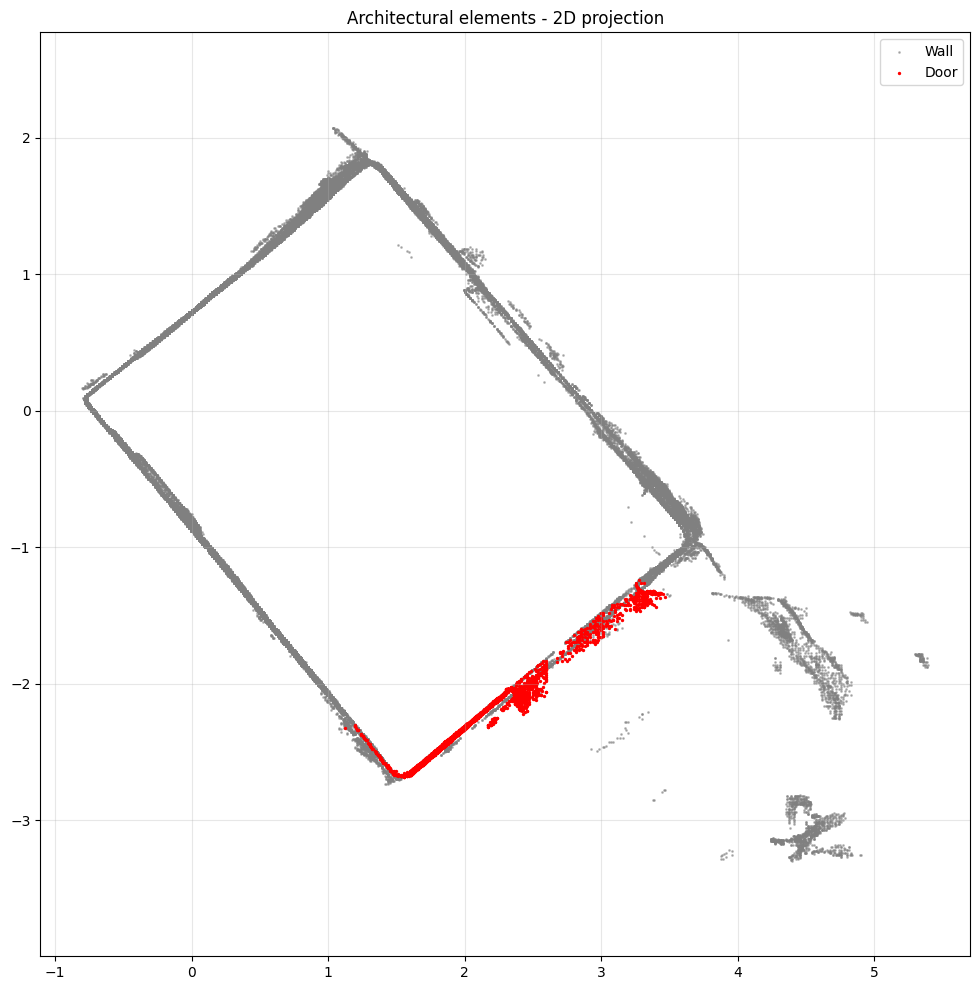

In [16]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [34]:
segment_models = {}
segments_ransac = {}

epsilon = 0.15
min_cluster_points = 50
max_plane_idx = 30
distance_threshold = 0.1
rest = sem_seg.pcd
for i in range(max_plane_idx):
    # colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=distance_threshold, ransac_n=3, num_iterations=2000)
    segments_ransac[i] = rest.select_by_index(inliers)
    labels = np.array(segments_ransac[i].cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
    candidates = [len(np.where(labels == j)[0]) for j in np.unique(labels)]
    best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])
    rest = rest.select_by_index(inliers, invert=True) + segments_ransac[i].select_by_index(list(np.where(labels != best_candidate)[0]))
    segments_ransac[i] = segments_ransac[i].select_by_index(list(np.where(labels == best_candidate)[0]))
    colors = plt.get_cmap("tab20")(i)
    segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # rest = rest.select_by_index(inliers, invert=True)
    
    # print("pass", i, "/", max_plane_idx, "done.")

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_28967/882629629.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])


In [35]:
o3d.visualization.draw_geometries([segments_ransac[i] for i in range(max_plane_idx)])

In [36]:
sem_seg.visualize_pcd()